<a href="https://colab.research.google.com/github/patbolan/MPHY5178_F21/blob/main/pulsetool/rf_pulse_simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is a simple notebook to simulate the excitation profile of an RF pulse.





In [ ]:
# First, some library imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
# Define the block simulation functions 
def dM_dt_function(b1x, b1y, R1, R2, Omega, M):
  dMdt = np.zeros([3]) # Initize the 3D vector

  # The three components of dM/dt: 
  dMdt[0] = Omega * M[1] - (b1y * M[2]) - (M[0] * R2)
  dMdt[1] = b1x * M[2] - (Omega * M[0]) - (M[1] * R2)
  dMdt[2] = b1y * M[0] - (b1x * M[1] + ((1.0 - M[2]) * R1))

  return dMdt

def blochRK4(Minit, B1x, B1y, Omega, R1, R2, deltaT):

  KK = np.zeros([4,3]) # 4 iterations, each holding a 3D vector [Mx, My, Mz]

  KK[0,:] = deltaT * dM_dt_function(B1x, B1y, R1, R2, Omega, Minit)
  KK[1,:] = deltaT * dM_dt_function(B1x, B1y, R1, R2, Omega, Minit + KK[0,:]/2)
  KK[2,:] = deltaT * dM_dt_function(B1x, B1y, R1, R2, Omega, Minit + KK[1,:]/2)
  KK[3,:] = deltaT * dM_dt_function(B1x, B1y, R1, R2, Omega, Minit + KK[2,:])

  # Take weighted sum of all K values
  Mnext = Minit + 1/6 * (KK[0,:] + 2*KK[1,:] + 2*KK[2,:] + KK[3,:] )

  return Mnext

# This calls blochRK4 for all timepoints in an RF pulse, and returns the 
# magnetization at the end of the RF pulse
def blochRK4_loop(B1x, B1y, Tp, offset, R1, R2, Minit):
  Npts = len(B1x)
  deltaTp = Tp / Npts
  Mnext = np.zeros([Npts,3])
  Mnext[0,:] = Minit

  for ndx in range(1,Npts):
    Mnext[ndx,:] = blochRK4(Mnext[ndx-1,:], B1x[ndx], B1y[ndx], offset, R1, R2, deltaTp)

  return Mnext[-1,:]

<function matplotlib.pyplot.show>

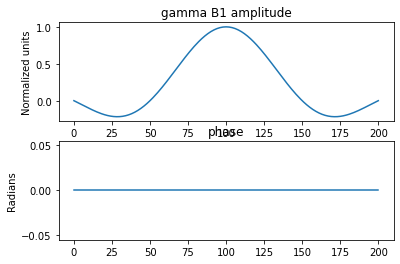

In [ ]:
# Load up an RF pulse file
# You can do this manually, by using the folder icon on the left <--
# Or in code, like this:
#    from google.colab import files
#    uploaded = files.upload()

# Either way, you'll have a file in the "current" directory. 
# Set the fname variable to that file name
fname = 'sinc3_201.RF'

# Load the file, using pandas. Convert to B1 mag, phase
df = pd.read_csv(fname, sep=' ', header=None)
b1_amp = df[1].to_numpy() / df[1].max() # Normalized B1 amplitude (actually gamma-B1)
b1_phase = df[0].to_numpy() * np.pi / 180 # Convert to radians

# Plot the shape
plt.subplot(2,1,1)
plt.plot(b1_amp)
plt.title('gamma B1 amplitude')
plt.ylabel('Normalized units')
plt.subplot(2,1,2)
plt.plot(b1_phase)
plt.title('phase')
plt.ylabel('Radians')
plt.show



In [ ]:
# Configure RF simulation
Tp = 0.005 # Pulse duration, seconds
gamma_b1_max = 222 # Pulse amplitude, Hz
pulse_phase = 0 # A global phase to apply to pulse. Radians

T1 = 1000.0 # s
T2 = 1000.0 # s

# Initial magnetization
M0 = np.array([0, 0, 1.0])

simulation_bw = 2000 # offresonance bandwidth to simulate
offset_steps = 200 # number of offres values to simulate 
offsets = np.zeros(offset_steps+1)

# Convert polar RF into cartesian components
b1x = 2 * np.pi * gamma_b1_max * b1_amp * np.cos(pulse_phase + b1_phase)
b1y = 2 * np.pi * gamma_b1_max * b1_amp * np.sin(pulse_phase + b1_phase)

Mt = np.zeros([offset_steps+1,3])
for idx in range(offset_steps+1):
  offsets[idx] = simulation_bw * 2 * np.pi * (2*idx/offset_steps -1)
  Mt[idx,:] = blochRK4_loop(b1x, b1y, Tp, offsets[idx], 1/T1, 1/T2, M0)



Text(0, 0.5, 'Mz')

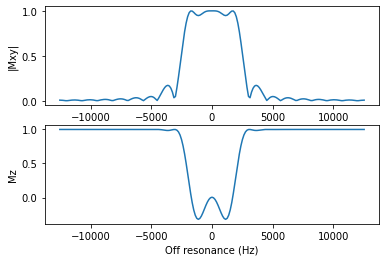

In [ ]:
# Plot the results
Mxy = np.sqrt(Mt[:,0]**2 + Mt[:,1]**2)

plt.subplot(2,1,1)
plt.plot(offsets, Mxy)
plt.xlabel('Off resonance (Hz)')
plt.ylabel('|Mxy|')

plt.subplot(2,1,2)
plt.plot(offsets, Mt[:,2])
plt.xlabel('Off resonance (Hz)')
plt.ylabel('Mz')